In [1]:
import os
from plotnine import *
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def getGenomeFile(genome_fasta, genome_txt):
    """
    return file for windows make
     <chromName><TAB><chromSize>
    """
    with open(genome_txt, 'w') as outFile:
        for seq in SeqIO.parse(genome_fasta, 'fasta'):
            outFile.write(seq.id + "\t" + str(len(seq.seq)) + '\n')
    return genome_txt


def intersectWithWindow(bam, window_file, outname):
    os.system(f'bedtools intersect -c -a {window_file} -b {bam} > {outname}')
    return outname
    
def _formatIntersectTab(intersectTab, read_number, prefix):
    norm_factor = read_number/10000
    pd_intersectTab = pd.read_csv(intersectTab, sep='\t', header=None)
    pd_intersectTab.columns = ['Chr', 'Start', 'End', 'Count']
    pd_intersectTab['sample'] = 'prefix'
    pd_intersectTab[f'Count_norm_{prefix}'] = pd_intersectTab['Count']/norm_factor
    
    print(f'Intersection for file {intersectTab} is done')
    return pd_intersectTab

def getFisherForTable(merge_pds, sample1_read_count, sample2_read_count):
    sample1_reads = list(merge_pds['Count'])
    sample2_reads = list(merge_pds['rawCount2'])
    pvalues = []
    cnt_for_corrections = 0
    for i, nreads in enumerate(sample1_reads):
        if (nreads == 0 and sample2_reads[i]) or (nreads/sample1_read_count < sample2_reads[i]/sample2_read_count):
            pvalues.append(1)
        else:
            pvalues.append(fisherTest([[nreads, sample2_reads[i]],[sample1_read_count, sample2_read_count]]))
            cnt_for_corrections += 1
    
    padusted = multipletests(pvalues, alpha=0.05,  method='fdr_bh')
    
    return padusted[1]

def getTabForPlot(intersectTab1, read_number1, prefix1, intersectTab2, read_number2, prefix2, min_log_ratio_to_be_up=2):
    pd1 = _formatIntersectTab(intersectTab1, read_number1, prefix1)
    pd2 = _formatIntersectTab(intersectTab2, read_number2, prefix2)
    ratio_id = f"{prefix1}_vs_{prefix2}"
    ## deterine ration between rca and wgsddm1
    pd1['idex'] = pd1['Chr'] + "_" + pd1['Start'].astype(str)
    pd2['idex'] = pd2['Chr'] + "_" + pd2['Start'].astype(str)
    merge_pds= pd.merge(
                pd1,pd2,
                how="inner",
                left_on='idex',
                right_on='idex')

    pd1[ratio_id] = merge_pds[f'Count_norm_{prefix1}']/(merge_pds[f'Count_norm_{prefix2}'] + 1)
    pd1[f'Count_norm_{prefix2}'] = merge_pds[f'Count_norm_{prefix2}']
    pd1[f'rawCount2'] = merge_pds[f'Count_y']

    
    min_log_ratio_to_be_up = 2
    pd1[ratio_id].replace(to_replace = 0.0, value = 1, inplace=True)
    pd1['log_ratio'] = np.log2(pd1[ratio_id])

    pd1['pvalue_corr'] = getFisherForTable(pd1, read_number1, read_number2)
    
    pd1['ratio_positive'] = ['up' if x < 0.05 else 'NS' for i, x in enumerate(list(pd1['pvalue_corr']))]

    
    return pd1

def PlotFileandSave(formatted_tab, outname_for_png, ratio_column_id,  
                    names_for_chromosomes = {'NC_003070.9':'Chr1', 'NC_003071.7':'Chr2', 'NC_003074.8':'Chr3', 
     'NC_003075.7':'Chr4', 'NC_003076.8':'Chr5', 
     'NC_037304.1':'Mitochondrial', 'NC_000932.1':'Chloroplast'}, chr_to_exclude = ['NC_037304.1', 'NC_000932.1']):
    
    def col_func(s):
        return names_for_chromosomes[s]



    fig, plot = (ggplot(formatted_tab[~formatted_tab['Chr'].isin(chr_to_exclude) ], aes(x='Start', y='log_ratio', color='ratio_positive')) + \
    geom_point(size=1) + \
    facet_wrap('Chr', ncol=1, scales='free_x', labeller=labeller(cols=col_func)) +\
                  scale_color_manual(values=["lightgrey", "red"]) + theme_linedraw() + \
                 theme(text=element_text(size=17)) + xlab('Chromosome position') + ylab(f'Log2({ratio_column_id})')
                ).draw(show=False, return_ggplot=True) 

    fig.set_size_inches(9, 12, forward=True)
    fig.savefig(outname_for_png, dpi=300)
    
    return outname_for_png


def mergeIntervals(pd_intersect, prefix1, prefix2, min_len = 500):
    chr_ids = list(pd_intersect[pd_intersect['ratio_positive']== 'up']['Chr'])
    start = list(pd_intersect[pd_intersect['ratio_positive']== 'up']['Start'])
    end= list(pd_intersect[pd_intersect['ratio_positive']== 'up']['End'])

    intervals = {}
    for i, chromos in enumerate(chr_ids):
        s, e = start[i], end[i]
        if chromos not in intervals:
            intervals[chromos] = [[s,e]]
        else:
            if s == intervals[chromos][-1][-1]:
                intervals[chromos][-1][-1] = e

            else:
                intervals[chromos].append([s,e])
    cnt_small = 0
    covered_intervals_len = []
    for i, chromos in enumerate(intervals):
        for ints in intervals[chromos]:
            row = [chromos, ints[0], ints[1], f'{chromos}:{ints[0]}..{ints[1]}']
            if ints[1] - ints[0] >= min_len:
                covered_intervals_len.append(row)
            else:
                cnt_small += 1
    
    pd_covered_intervals_bed = pd.DataFrame(covered_intervals_len)
    print(f'Number of intervals for selection: {len(intervals)}', 'Before merging:', len(pd_intersect[pd_intersect['ratio_positive']== 'up']))
    print('Number of intervals selected', len(pd_covered_intervals_bed))
    print('Number of intervals filtered out because small length', cnt_small)
    
    return pd_covered_intervals_bed

def getNewCountsForMergedIntervals(bam1, bam2, mergeintervalsTab, prefix1, prefix2, outfolder):
    count1 = intersectWithWindow(bam1, mergeintervalsTab, f'{outfolder}/{prefix1}_merged_intervals.intersect')
    pd_intersectTab1 = pd.read_csv(count1, sep='\t', header=None)
    pd_intersectTab1.columns = ['Chr', 'Start', 'End', 'JB_id', f'Count_{prefix1}']
    
    count2 = intersectWithWindow(bam2, mergeintervalsTab, f'{outfolder}/{prefix2}_merged_intervals.intersect')
    pd_intersectTab2 = pd.read_csv(count2, sep='\t', header=None)
    pd_intersectTab2.columns = ['Chr', 'Start', 'End', 'JB_id', f'Count_{prefix2}']
    
    return pd.concat([pd_intersectTab1, pd_intersectTab2[f'Count_{prefix2}']], axis=1)

def fisherTest(matrix):
    table = np.array(matrix)
    table += 1
    res = fisher_exact(table, alternative='greater')

    return res[-1]



# 1. VARIABLES (CHANGE THEM!)

In [4]:
genome = '/home/ikirov/JUPYTER_notebooks/eccDNA_ONT_sequencing/DATA/GCF_000001735.4_TAIR10.1_genomic.fna'
window_size = 500

out_folder = './new_scatter_files'

#########################################################################################
sample1_bam = './mapping/sorted_rep0_eccDNA_stress_HS_TH_selected_minC_2.bamfiltered.bam'
prefix1 = 'HS1'
sample1_read_count = 11916

sample2_bam = './sorted_mapping_merged_rep1_rep2_ZA.bamfiltered.bam'
prefix2 = 'ZAm' 
sample2_read_count =  28885 + 39517
#########################################################################################

#min ratio to select as positively regulated
min_log_ratio_to_be_up = 2

getWindowFile  = False
genome_text = './scatter_plot_files/GCF_000001735.4_TAIR10.1_genomic.fna_genome_text' 
windows_file = './scatter_plot_files/GCF_000001735.4_TAIR10.1_genomic.fna_windoe_500.bed'

## genome txt file for making windows file

### genome_txt file, or run getGenomeFile(genome, genome_text) if it does not exist
if getWindowFile:
    genome_text = getGenomeFile(genome, genome_text) 
    os.system(f"bedtools makewindows -g {genome_text} -w {window_size} > {windows_file}")

# 2. Prepare files for plot

In [5]:
intersectTab1 = intersectWithWindow(sample1_bam, windows_file, f"{out_folder}/{prefix1}.intersect")
intersectTab2 = intersectWithWindow(sample2_bam, windows_file, f"{out_folder}/{prefix2}.intersect")
pd_sample1_with_ratio = getTabForPlot(intersectTab1, sample1_read_count, prefix1, 
                                      intersectTab2, sample2_read_count, prefix2, 
                                      min_log_ratio_to_be_up=2)

Intersection for file ./new_scatter_files/HS1.intersect is done
Intersection for file ./new_scatter_files/ZAm.intersect is done


In [6]:
pd_sample1_with_ratio[pd_sample1_with_ratio['pvalue_corr'] < 0.05]

,Chr,Start,End,Count,sample,Count_norm_HS1,idex,HS1_vs_ZAm,Count_norm_ZAm,rawCount2,log_ratio,pvalue_corr,ratio_positive
7561,NC_003070.9,3780500,3781000,126,prefix,105.740181,NC_003070.9_3780500,73.502976,0.438584,3,6.199731,9.465961e-95,up
7562,NC_003070.9,3781000,3781500,127,prefix,106.579389,NC_003070.9_3781000,74.086333,0.438584,3,6.211136,1.558867e-95,up
7563,NC_003070.9,3781500,3782000,117,prefix,98.187311,NC_003070.9_3781500,68.252764,0.438584,3,6.092816,1.773473e-87,up
7564,NC_003070.9,3782000,3782500,46,prefix,38.603558,NC_003070.9_3782000,29.869919,0.292389,2,4.900621,1.557283e-31,up
7565,NC_003070.9,3782500,3783000,12,prefix,10.070493,NC_003070.9_3782500,10.070493,0.000000,0,3.332062,1.115657e-06,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239008,NC_037304.1,356000,356500,22,prefix,18.462571,NC_037304.1_356000,6.365242,1.900529,13,2.670215,3.621542e-07,up
239109,NC_000932.1,38500,39000,103,prefix,86.438402,NC_000932.1_38500,1.945944,43.419783,297,0.960470,3.359337e-05,up
239110,NC_000932.1,39000,39500,102,prefix,85.599194,NC_000932.1_39000,2.062835,40.495892,277,1.044629,3.300344e-06,up
239111,NC_000932.1,39500,40000,111,prefix,93.152064,NC_000932.1_39500,2.415018,37.572001,257,1.272034,3.147431e-10,up


# 3. Plot

/home/ikirov/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


'./new_scatter_files/HS1_vs_ZAm.png'

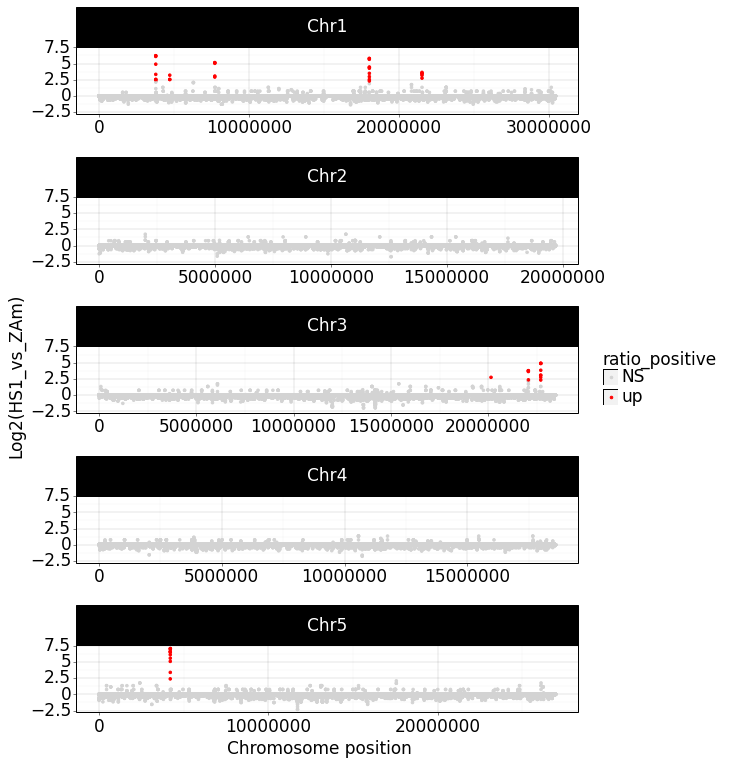

In [7]:
outname_for_png = f"{out_folder}/{prefix1}_vs_{prefix2}.png"
ratio_column_id = f"{prefix1}_vs_{prefix2}"
PlotFileandSave(pd_sample1_with_ratio, outname_for_png, ratio_column_id, 
                    names_for_chromosomes = {'NC_003070.9':'Chr1', 'NC_003071.7':'Chr2', 'NC_003074.8':'Chr3', 
     'NC_003075.7':'Chr4', 'NC_003076.8':'Chr5', 
     'NC_037304.1':'Mitochondrial', 'NC_000932.1':'Chloroplast'}, chr_to_exclude = ['NC_037304.1', 'NC_000932.1'])

In [8]:
# 4. Merge neighbor intervals and get table with up-regulated loci

pd_selected_up = mergeIntervals(pd_sample1_with_ratio[~pd_sample1_with_ratio['Chr'].isin(['NC_037304.1', 'NC_000932.1']) ], 
                                prefix1, prefix2, min_len = 1000)

outfile_for_bed_with_new_merged_intervals = f"{out_folder}/{prefix1}_vs_{prefix2}_new_mergedIntervale.bed"
pd_selected_up.to_csv(outfile_for_bed_with_new_merged_intervals, header=True, index=False, sep='\t')

Number of intervals for selection: 3 Before merging: 55
Number of intervals selected 11
Number of intervals filtered out because small length 3


In [9]:
concat_tabs = getNewCountsForMergedIntervals(sample1_bam, sample2_bam, outfile_for_bed_with_new_merged_intervals, 
                               prefix1, prefix2, out_folder)

concat_tabs

,Chr,Start,End,JB_id,Count_HS1,Count_ZAm
0,0,1,2,3,0,0
1,NC_003070.9,3780500,3783500,NC_003070.9:3780500..3783500,127,3
2,NC_003070.9,3785000,3786000,NC_003070.9:3785000..3786000,8,1
3,NC_003070.9,4714500,4716000,NC_003070.9:4714500..4716000,11,3
4,NC_003070.9,7717000,7719000,NC_003070.9:7717000..7719000,42,0
5,NC_003070.9,18013000,18015500,NC_003070.9:18013000..18015500,212,16
6,NC_003070.9,18016000,18018500,NC_003070.9:18016000..18018500,57,9
7,NC_003070.9,21524500,21527000,NC_003070.9:21524500..21527000,17,2
8,NC_003074.8,22059500,22061000,NC_003074.8:22059500..22061000,21,2
9,NC_003074.8,22695500,22697000,NC_003074.8:22695500..22697000,10,0


In [11]:
concat_tabs['countHS1_per_10Kb'] = concat_tabs['Count_HS1']/(11000/10000)
concat_tabs['countZAm_per_10Kb'] = concat_tabs['Count_ZAm']/(70000/10000)

In [13]:
concat_tabs.to_csv(f'{out_folder}/{prefix1}_vs_{prefix2}.selected_intervals.tab', header=True, index=False, sep='\t')